In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import multiprocessing

In [2]:
import RouteMap as rm
import BusModel as bm
import Helper_Methods as hm

In [3]:
route = 22
concat_val = 6
period = "AM"

In [4]:
route_path = "./Data/Routes/rt{}_pts.shp".format(route)
stops_path = "./Data/Transit_Stops/Transit_Stops_for_King_County_Metro__transitstop_point.shp"
signals_path = "./Data/Signals/Traffic_Signals.shp"
seattle_streets_data = "./Data/Seattle_Streets/Seattle_Streets.shp"

route_raw = gpd.read_file(route_path)
stops = gpd.read_file(stops_path)
signals = gpd.read_file(signals_path)
seattle_streets = gpd.read_file(seattle_streets_data)

In [5]:
route_concat = route_raw[::6]
route_concat = route_concat.reset_index(drop=True)

route_geometry = route_concat['geometry']
route_elevation = route_concat['Z']
all_stops = stops.copy()
all_signals = signals['geometry'].reset_index(drop=True)
route_stops = hm.get_stops(all_stops, str(route))['geometry'].reset_index(drop=True)
limits = seattle_streets[['geometry', 'SPEEDLIMIT']]

In [6]:
#route_test_map = rm.RouteMap(route_geometry, route_elevation, limits, route_stops, all_signals, debug = True)
#(route_test_map.get_gdf()).to_csv('rt22.csv')

In [7]:
route_test_map = rm.RouteMap(route_geometry, route_elevation)
route_test_map = route_test_map.load_from_gdf('rt22.csv')

C:\Users\Sebastian\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0.5, 1.0, 'Distance vs. Elevation and Grade')

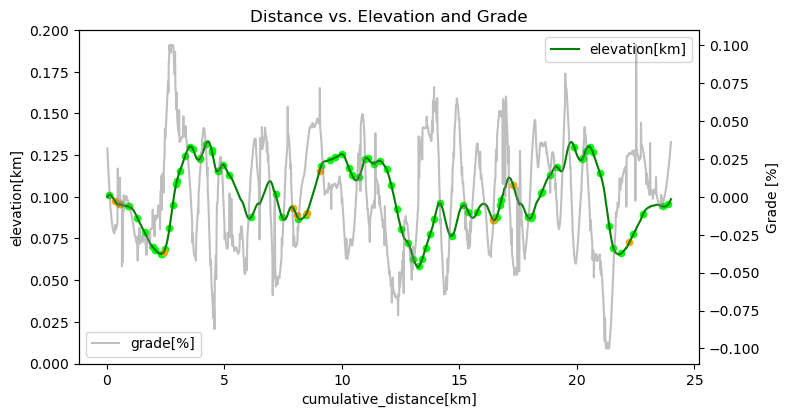

In [8]:
sm_elev = route_test_map.smooth_elevation()
route_sm_map = route_test_map.set_elevation(sm_elev)
route_sm_map.plot()
plt.title('Distance vs. Elevation and Grade')

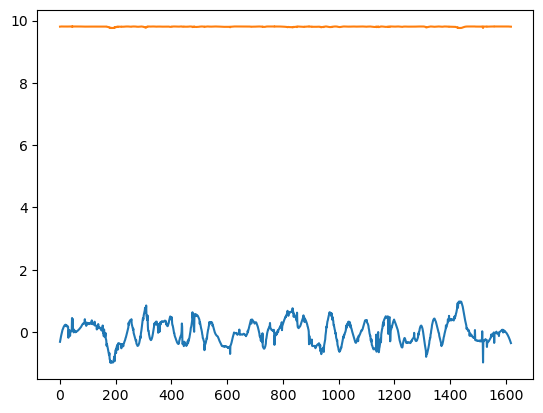

In [9]:
y = route_test_map.get_hill_accel()
x = route_test_map.get_hill_accel().index
y2 = route_test_map.get_fric_accel()
x2 = route_test_map.get_fric_accel().index
plt.plot(x, y)
plt.plot(x2, y2)

In [10]:
ridership_path = "./Data/Trip_Data/Zon183Unsum.csv"
acc_prof_path = "./Data/Accel_Prof/acceleration.csv"

kcm_ridership = pd.read_csv(ridership_path)
raw_acc_prof = pd.read_csv(acc_prof_path, names=['time[s]', 'accel.[g]'])

route_data = kcm_ridership[(kcm_ridership['Route']==route) & (kcm_ridership['Period']==period)]

In [11]:
sorted_route = route_data.sort_values(by=['InOut','Trip_ID', 'STOP_SEQ', 'STOP_ID'])
sorted_route = sorted_route[['InOut','STOP_SEQ', 'STOP_ID', 'AveOn', 'AveOff', 'AveLd']]
sorted_route = sorted_route.drop_duplicates(subset=['InOut','STOP_SEQ'], keep='first')
sorted_route = sorted_route.drop_duplicates(subset='STOP_ID', keep='first')
sorted_route = sorted_route.reset_index(drop = True)
sorted_route['Index'] = sorted_route.index

a_prof = raw_acc_prof.copy()
a_prof['accel.[m/s^2]'] = a_prof['accel.[g]'] * 9.81
a_prof = a_prof.drop(columns = ['accel.[g]'])

In [12]:
sorted_route

InOut  STOP_SEQ  STOP_ID  AveOn  AveOff  AveLd  Index
0      I       1.0    22264    0.0     0.0    0.0      0
1      I       2.0    22280    0.0     0.0    0.0      1
2      I       3.0    22290    0.0     0.0    0.0      2
3      I       4.0    22300    0.2     0.0    0.2      3
4      I       5.0    22320    0.0     0.0    0.2      4
..   ...       ...      ...    ...     ...    ...    ...
81     O      26.0    39976    0.0     0.0    1.6     81
82     O      27.0    39980    0.2     0.6    1.2     82
83     O      28.0    39990    0.0     0.2    1.1     83
84     O      29.0    22260    1.0     0.0    2.1     84
85     O      30.0    22261    0.0     0.0    2.0     85

[86 rows x 7 columns]

In [263]:
import pandas as pd
import numpy as np

class Bus_Model:
    def __init__(self,
                 acceleration_profile, # two column dataframe containing time(s), accel(m/s^2)
                 raw_mass = 13041, # kilograms, unknown bus model
                 bus_width = 2.6, # meters, unknown bus model
                 bus_height = 3.3, # meters, unknown bus model
                 drag_coeff = 0.6, # default from unknown bus model
                 wheel_rad = 0.5, # meters, unknown bus model
                 factor = 1.1, # intertial factor.
                 fric_coeff = .01, # default from erica's
                 motor_eff = .916, # unknown source
                 invert_eff = .971, # unknown source
                 regen = .6, # unknown source
                 eff_aux = .89, # unknown source
                 a_braking = -1.5, #m/s^2
                 final_a = .4, # m/s^2, defualt acceleration after profile finishes
                 max_velocity = 26.8224, # m/s, = 60 mph
                 maintain_acceleration = False, # boolean for if bus should maintain the last a in 
                                                # profile or use final_a for extrapolating new vals
                 num_starting_passengers = 0,
                 pass_ave_mass = 80, #kg
                
                 ):
        # raw bus characteristics
        self._empty_mass = raw_mass
        self._bus_width = bus_width
        self._bus_height = bus_height
        self._bus_front_area = self._bus_width * self._bus_height
        self._drag_coeff = drag_coeff
        self._wheel_rad = wheel_rad
        self._i_factor = factor
        self._fric_coeff = fric_coeff
        self._motor_eff = motor_eff
        self._invert_eff = invert_eff
        self._regen = regen
        self._eff_aux = eff_aux
        
        # driving model characteristics
        self._a_braking = a_braking
        self._final_a = final_a
        self._final_a_boolean = maintain_acceleration
        self._max_v = max_velocity
        self._accel_profile_df = self.interpret_accel_prof(acceleration_profile)
        
        # variables based on position in route
        self._passengers = num_starting_passengers
        self._mass_p_pass = pass_ave_mass
        self._current_velocity = 0
        self._current_accel = 0
        self._distance_traveled = 0
        self._bus_status = "Stopped"
        self._current_mass = self._empty_mass + self._passengers * self._mass_p_pass
        
        
    def interpret_accel_prof(self, accel_prof):
        """
        interpret_accel_prof is used to format the acceleration
        profile so as to have velocity and distance traveled.
        
        Parameters:
        accel_prof: dataframe of time and acceleration values,
                    in seconds and m/s^2.
        
        Returns: 
        dataframe of time, acceleration, velocity, and distance
        in seconds and meters units.
        """
        # Generate a copy of the profile
        acc_prof = accel_prof.copy()
        
        # Get the changes in time
        acc_prof['dt'] = acc_prof['time[s]'].diff()
        
        # use mean_integral to get the velocity data
        acc_prof['vel.[m/s]'] = self.mean_integral(acc_prof['dt'], acc_prof['accel.[m/s^2]'])
        
        # use mean_integral to get the distance data
        acc_prof['dist.[m]'] = self.mean_integral(acc_prof['dt'], acc_prof['vel.[m/s]'])
        
        while (not (acc_prof['vel.[m/s]'].iloc[-1] >= self._max_v)):
            
            # Generate a new row dictionary from the columns
            new_row = dict.fromkeys(list(acc_prof.columns))
            
            # set the step time to be 1 second
            d_t = 1
            
            # calculate the next time point using the previous and dt
            next_time = acc_prof['time[s]'].iloc[-1] + d_t 
            
            # default to using the _final_a acceleration
            next_accel = self._final_a
            
            # if the parameters say to maintain acceleration,
            if self._final_a_boolean:
                # Keep the last acceleration
                next_accel = acc_prof['accel.[m/s^2]'].iloc[-1]
            
            # calculate the next velocity
            next_v = acc_prof['vel.[m/s]'].iloc[-1] + d_t*next_accel
            
            # calculate the next distance
            next_d = acc_prof['dist.[m]'].iloc[-1] + d_t * (next_v + acc_prof['vel.[m/s]'].iloc[-1]) / 2
            
            # generate the list of data
            data = [next_time, next_accel, d_t, next_v, next_d]
            
            # put the data into the dictionary
            for i in range(len(data)): new_row[list(new_row.keys())[i]] = data[i]
            
            # Append the new row on to the profile dataframe
            acc_prof.loc[len(acc_prof)] = new_row
            
        # drop the dt column
        #acc_prof = acc_prof.drop(columns = ['dt'])
        
        # return the acceleration profile dataframe
        return acc_prof
    
    
    def mean_integral(self, time_changes, value_series):
        """
        mean_integral takes in a series of dt (s) values, and
        a corresponding series of other values to be integrated
        with respect to time, and provides the result as a
        cumulative summing series. 

        Parameters:
        time_changes: a pandas series of dT values in units of seconds
        value_series: a pandas series of d[value] that has relation to time.

        Returns: 
        a pandas series of the integrated values.
        """
        int_prof = pd.DataFrame()
        int_prof['mean_val_btw'] = value_series.rolling(window=2).mean()
        int_prof['d[value]'] = int_prof['mean_val_btw'] * time_changes
        int_prof['integrated'] = int_prof['d[value]'].cumsum()

        return int_prof['integrated'].fillna(0)
    
    
    def get_accel_profile(self):
        return self._accel_profile_df
    
    
    def velocity(self):
        return self._current_velocity
    
    
    def set_v(self, v):
        self._current_velocity = v
    
    
    def max_velocity(self):
        return self._max_v
    
    def accelerate(self, dist):
        prev_v = self._current_velocity
        prof = self.get_accel_profile().copy()
        closest_v = prof.iloc[(prof['vel.[m/s]'] - prev_v).abs().argsort()[:1]]
        starting_index = (list(closest_v.index))[0]
        prof['accel_dist'] = prof['dist.[m]'] - int(closest_v['dist.[m]']) - dist
        zeroed_v = prof.iloc[(prof['accel_dist'] - 0).abs().argsort()[:1]]
        final_index = (list(zeroed_v.index))[0]
        self._current_velocity = prof['vel.[m/s]'][final_index]
        self._distance_traveled = dist + self._distance_traveled
        self._bus_status = 'moving'
        return self
    
    
    def brake(self, dist):
        v2 = self._current_velocity**2
        dv2 = self._a_braking*dist*2
        final_v = 0
        if (v2>np.abs(dv2)):
            #print(v2 + dv2)
            final_v = np.sqrt(self._current_velocity**2 + 2*self._a_braking*dist)
        self._current_velocity = final_v
        return self
    
    
    def get_braking_distance(self, velocity, ext_acc):
        
        # Using the kinematics equation vf^2 = vi^2 + 2a(dX) to get
        # braking distance
        return -velocity**2 / (2*(self._a_braking - ext_acc))

    
    def get_aerodynamic_drag(self, wind_speed, air_density):
        air_drag = self._drag_coeff * self._bus_front_area * (air_density/2) * (self._current_velocity - wind_speed)**2
        return air_drag # acceleration of drag
    
    
    def get_inertial_force(self):
        inertia = self._i_factor * self._current_mass * self._current_accel
        return inertia # Force of inertia
    
    
    def update_riders(self, val, cat='change'):
        # Update passenger number, sum should never be < 0
        
        if (cat=='change'):
            self._passengers = self._passengers + val
        elif (cat == 'set'):
            self._passengers = val
        
        # Update total mass
        self._current_mass = self._empty_mass + self._passengers * self._mass_p_pass
        return None
    
    def get_n_riders(self):
        return self._passengers
    
    def get_mass(self):
        return self._current_mass
    
    def get_fric_coeff(self):
        return self._fric_coeff

    def get_b_accel(self):
        return self._a_braking

In [259]:
default_bus = Bus_Model(a_prof)

In [260]:
default_bus = Bus_Model(a_prof)
default_bus.accelerate(14.985273207016998)
print(default_bus.velocity())

5.470000012158476


In [279]:
class Trip_Dynamics:
    def __init__(self, route_map, bus_model, bus_ridership, ridership_type='mean', seed=None):
        self._route_map = route_map
        self._bus_model = bus_model
        self._ridership_type = ridership_type
        self._rand_seed = seed
        if (self._ridership_type == 'mean'):
            self._ridership = bus_ridership
        elif (self._ridership_type == 'chance'):
            self._ridership = self.riders_from_chance(bus_ridership)
        self._route_data = self._route_map.get_gdf()
        self._route_data['riders'] = self.generate_rider_profile()
        #self._route_data['f_bus'] = self.bus_trip_force()
        self._route_data['bus_mass'] = self.generate_mass_profile()
        self._route_data['f_grav'] = self._route_data['bus_mass'] * self._route_map.get_hill_accel()
        self._route_data['f_fric'] = self._route_data['bus_mass'] * self._route_map.get_fric_accel()  * self._bus_model.get_fric_coeff() 
        
    
    def _riders_from_chance(self, ridership_probs):
        '''
        UNFINISHED
        riders_from_chance takes in a series of probabilities for a change in
        ridership of x of the bus, and returns a series of
        changes in bus ridership that corresponds
        '''
        np.random_seed(self._rand_seed)
        deltas = [0, 1]
        
    
    def generate_rider_profile(self):
        '''
        generate_rider_profile generates a pandas series that contains the
        current amount of riders based on bus position
        
        Parameters:
        None
        
        Returns:
        pandas series matching length of route, with ridership numbers.
        Indicies identical to the route.
        '''
        
        # Copy the ridership changes as d_riders
        d_riders = self._ridership.copy()
        
        # get the series of stop booleans for the route
        stop_bools = self._route_data['is_stop'].copy()
        
        # create a new dataframe based on the stop booleans
        df = pd.DataFrame(stop_bools, columns=['is_stop'])
        
        # default change in riders is 0
        df['d_riders'] = 0
        
        # get a list of indexes on the route that are stops
        stop_indexes = list(df[df['is_stop']==True].index)
        
        # At the stops, add the change in riders
        df.iloc[stop_indexes, df.columns.get_loc('d_riders')] = d_riders
        
        # make the cumulative riders and return it
        df['riders'] = df['d_riders'].cumsum()
        return df['riders']
    
    

    def generate_mass_profile(self):
        '''
        generate_mass_profile generates a pandas series
        containing the total bus mass at each point along
        the trip, based on the ridership information of the route.
        
        Parameters:
        None
        
        Returns:
        a pandas series containing the total bus mass
        at each point on the route, indexed the same.
        '''
        
        # Copy the stops and riders
        stop_bools = self._route_data['is_stop'].copy()
        n_riders = self._route_data['riders'].copy()
        
        # Generate a new dataframe from the stop booleans
        df = pd.DataFrame(stop_bools, columns=['is_stop'])
        
        # Add the default bus mass to the dataframe
        df['total_mass'] = self._bus_model.get_mass()
        
        # add the ridership column to the dataframe
        df['n_riders'] = n_riders
        
        # get stop indexes
        stop_indexes = df[df['is_stop']==True].index
        
        # Get the column indexes of mass and riders
        mass_col_id = df.columns.get_loc('total_mass')
        rider_col_id = df.columns.get_loc('n_riders')
        
        # Loop through each stop,
        for i in range(len(stop_indexes)):
            
            # Get the current route point index
            cur_idx = stop_indexes[i]
            
            # get the ridership value for this index
            rider_val = df.iloc[cur_idx, rider_col_id]
            
            # Set the bus model's riders to the rider value
            self._bus_model.update_riders(rider_val, 'set')
            
            # Get the mass of the bus model
            df.iloc[cur_idx:, mass_col_id] = self._bus_model.get_mass()
        
        # return the total mass series
        return df['total_mass']

    
    def get_mass_profile(self):
        return self._route_data['bus_mass']
    

    def bus_trip(self):
        route = self._route_map.get_gdf()
        route['is_stop'][:-2] == True
        fric_a_prof = self._route_map.get_fric_accel()
        hill_a_prof = self._route_map.get_hill_accel()
        bus = self._bus_model
        bus_f_coef = bus.get_fric_coeff()
        max_v = bus.max_velocity()
        route['vel.[m/s]'] = 0
        route['stop_dist[m]'] = 0
        accel_profile = bus.get_accel_profile()
        vel_list = []
        dist_list = []
        for i in range(1, len(route)-1):
            point_dist = route['point_distances[km]'][i]*1000
            cum_dist = route['cumulative_distance[km]'][i]*1000
            cum_dist_col_id = route.columns.get_loc('cumulative_distance[km]')
            remaining_trip = route.iloc[i:]
            dist_to_stop = 0
            stops_remain = remaining_trip[(remaining_trip['is_stop'] == True) | (remaining_trip['is_signal'] == True)]['cumulative_distance[km]'].reset_index(drop=True)
            if (len(stops_remain) != 0):
                dist_to_stop = stops_remain[0]*1000-cum_dist
            start_velocity = bus.velocity()
            a_drag = bus.get_aerodynamic_drag(0, 1.2)
            a_fric = fric_a_prof[i]*bus_f_coef
            a_hill = hill_a_prof[i]
            
            ext_a = a_drag + a_fric + a_hill
            
            stopping_dist = bus.get_braking_distance(start_velocity, ext_a) #meters
            point_sp_lim = route['speed_limit[km/s]'][i]
            if ((start_velocity == 0)):
                bus.accelerate(point_dist)
            elif(stopping_dist*1000 >= dist_to_stop):
                bus.brake(point_dist)
            elif(start_velocity < point_sp_lim*1000):
                bus.accelerate(point_dist)
            elif(start_velocity > point_sp_lim*1000):
                b_dist = ((point_sp_lim*1000)**2 - start_velocity**2)/2 /(bus.get_b_accel())
                bus.brake(b_dist)
            vel_list.append(bus.velocity())
            dist_list.append(dist_to_stop)
        route.iloc[1:-1, route.columns.get_loc('stop_dist[m]')] = dist_list
        route.iloc[1:-1, route.columns.get_loc('vel.[m/s]')] = vel_list
        return route
                
            
        #apply to each point:
        # If velocity is zero, begin accelerating
        # if velocity is = limit, cease accelerating
        # Check if signal is active
        # if distance to next stop is equal to braking dist for current veolcity,
            # brake
        

In [288]:
default_bus = Bus_Model(a_prof)
sorted_route_diff = sorted_route['AveOn'] - sorted_route['AveOff']
td = Trip_Dynamics(route_test_map, default_bus, sorted_route_diff)
trip = td.bus_trip()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(trip['stop_dist[m]'])

Index(['geometry', 'elevation[km]', 'latitude', 'longitude',
       'point_distances[km]', 'cumulative_distance[km]', 'speed_limit[km/s]',
       'is_stop', 'is_signal', 'grade[%]', 'riders', 'bus_mass', 'vel.[m/s]',
       'stop_dist[m]'],
      dtype='object')
0          0.000000
1         89.911633
2         74.926360
3         59.941086
4         44.955813
5         29.970540
6         14.985271
7          0.000000
8        205.471170
9        190.669372
10       178.129924
11       163.281678
12       148.433434
13       133.585191
14       118.736949
15       103.888709
16        89.040471
17        74.192235
18        59.344000
19        44.495766
20        29.647535
21        14.799305
22         0.000000
23       163.332483
24       148.484114
25       133.635737
26       118.787352
27       103.938960
28        89.090560
29        74.242152
30        59.393736
31        44.545312
32        29.696881
33        14.848442
34         0.000000
35        29.696982
36        14.8484

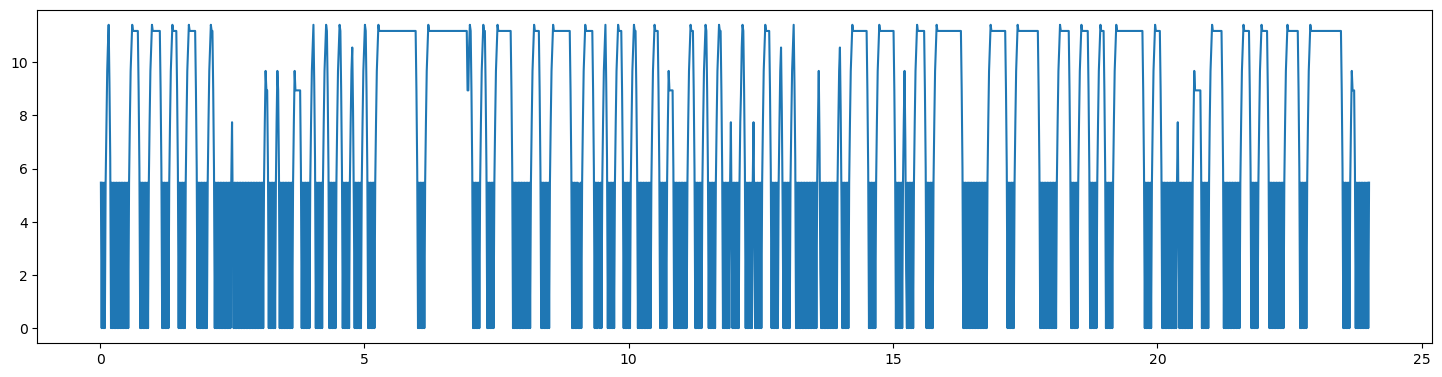

In [281]:
x = trip['cumulative_distance[km]']
y = trip['vel.[m/s]']
fig, ax = plt.subplots(1, figsize = (18, 4.333))
plt.plot(x, y)

In [284]:
stoppp = trip[(trip['is_stop']==True) | (trip['is_signal']==True)]
stoppp

geometry  elevation[km]  \
7      POINT (-122.38710558186402 47.56294580154749)       0.101211   
22     POINT (-122.38678398279127 47.56105347087197)       0.097704   
34       POINT (-122.386830293521 47.55930024473119)       0.095395   
37    POINT (-122.38684315427201 47.558861973940346)       0.095430   
61      POINT (-122.38692863852972 47.5559317380421)       0.094356   
...                                              ...            ...   
1498   POINT (-122.38719540980176 47.54667668065439)       0.072773   
1509  POINT (-122.38714954840518 47.548283710082856)       0.077457   
1538  POINT (-122.38703139528182 47.552354549886246)       0.089641   
1594   POINT (-122.38804079441495 47.55933873550691)       0.094204   
1610   POINT (-122.38813048425878 47.56153626335261)       0.095370   

        latitude  longitude  point_distances[km]  cumulative_distance[km]  \
7    -122.387106  47.562946             0.014985                 0.104897   
22   -122.386784  47.561053             0.014799                 0.325353   
34   -122.386830  47.559300             0.014848                 0.503534   
37   -122.386843  47.558862             0.014848                 0.548080   
61   -122.386929  47.555932             0.014849                 0.877353   
...          ...        ...                  ...                      ...   
1498 -122.387195  47.546677             0.014849                22.235869   
1509 -122.387150  47.548284             0.014849                22.399210   
1538 -122.387031  47.552355             0.014849                22.816986   
1594 -122.388041  47.559339             0.014985                23.646103   
1610 -122.388131  47.561536             0.014851                23.883411   

      speed_limit[km/s] is_stop is_signal  grade[%]  riders  bus_mass  \
7              0.011176    True     False  0.004071     0.0     13041   
22             0.011176   False      True -0.021582     0.0     13041   
34             0.011176   False      True -0.006559     0.0     13041   
37             0.011176    True     False  0.012520     0.0     13041   
61             0.011176    True     False -0.002069     0.0     13041   
...                 ...     ...       ...       ...     ...       ...   
1498           0.011176   False      True  0.028399     0.9     13113   
1509           0.011176    True     False  0.030210     0.5     13081   
1538           0.011176    True     False  0.030361     0.3     13065   
1594           0.008941    True     False -0.004873     1.3     13145   
1610           0.008941    True     False  0.016454     1.3     13145   

      vel.[m/s]  stop_dist[m]  
7          5.47           0.0  
22         0.00           0.0  
34         0.00           0.0  
37         5.47           0.0  
61         0.00           0.0  
...         ...           ...  
1498       0.00           0.0  
1509       5.47           0.0  
1538       0.00           0.0  
1594       5.47           0.0  
1610       5.47           0.0  

[96 rows x 14 columns]

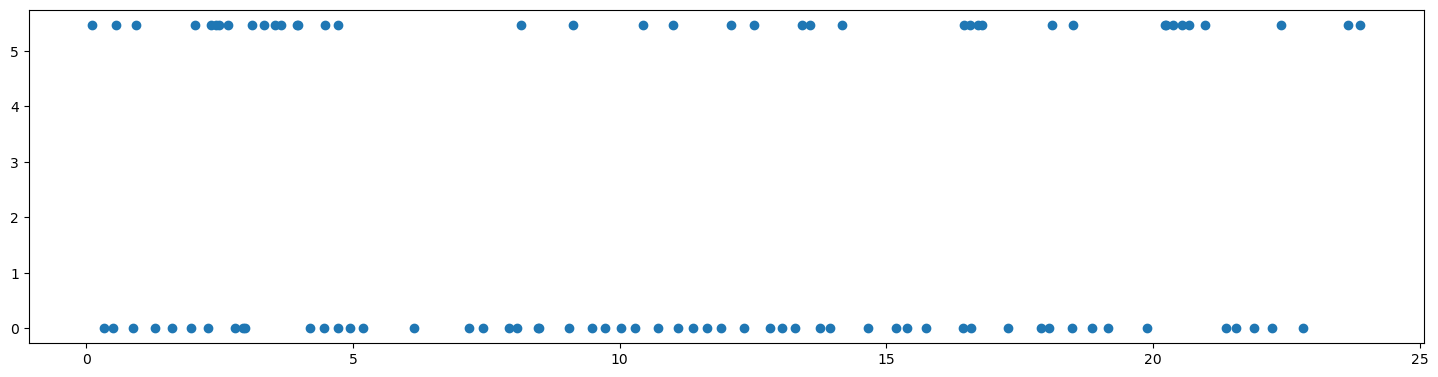

In [283]:
x = stoppp['cumulative_distance[km]']
y = stoppp['vel.[m/s]']
fig, ax = plt.subplots(1, figsize = (18, 4.333))
plt.scatter(x, y)